In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import torch
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)

# 1,000 단위 표기
pd.options.display.float_format = '{:,.5f}'.format

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 6)

# 경고 무시
warnings.filterwarnings('ignore')

# Data 경로 설정
DATA_DIR = 'data'

# 시드설정
SEED = 123

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

%matplotlib inline

In [2]:
# FinanceDataReader 설치
!pip install finance-datareader -q
!pip install plotly -q

In [5]:
import FinanceDataReader as fdr

# 삼성전자 주가 데이터 로드
df = fdr.DataReader("005930")
df = df.drop("Change", axis=1)
df.head(20)

,Open,High,Low,Close,Volume
Date,,,,,
1999-11-08,4340,4350,4190,4200,612169
1999-11-09,4220,4460,4170,4430,947061
1999-11-10,4400,4420,4300,4320,707761
1999-11-11,4390,4480,4320,4330,747622
1999-11-12,4440,4750,4420,4600,1189695
1999-11-15,4800,4800,4510,4540,687524
1999-11-16,4500,4700,4460,4700,737667
1999-11-17,4780,4840,4500,4520,857492
1999-11-18,4480,4580,4420,4550,655310


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaled[:5]

array([[0.04806202, 0.04493802, 0.04681564, 0.01665345, 0.00677882],
       [0.04673311, 0.04607438, 0.04659218, 0.01925909, 0.01048722],
       [0.04872647, 0.04566116, 0.04804469, 0.01801291, 0.00783735],
       [0.04861573, 0.04628099, 0.04826816, 0.0181262 , 0.00827875],
       [0.04916944, 0.04907025, 0.04938547, 0.021185  , 0.01317402]])

In [6]:
scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
scaled_df

,Open,High,Low,Close,Volume
Date,,,,,
1999-11-08,0.04806,0.04494,0.04682,0.01665,0.00678
1999-11-09,0.04673,0.04607,0.04659,0.01926,0.01049
1999-11-10,0.04873,0.04566,0.04804,0.01801,0.00784
1999-11-11,0.04862,0.04628,0.04827,0.01813,0.00828
1999-11-12,0.04917,0.04907,0.04939,0.02119,0.01317
...,...,...,...,...,...
2024-02-22,0.81728,0.76343,0.81229,0.79721,0.16842
2024-02-23,0.81506,0.76653,0.81453,0.79495,0.17967
2024-02-26,0.80066,0.75620,0.80670,0.79381,0.16244


## Windowed Dataset


In [7]:
N_PREDICTIONS = 1
N_FEATURES = 4
WINDOW_SIZE = 10

In [8]:
def make_dataset(series, target, window_size=WINDOW_SIZE, n_predictions=N_PREDICTIONS):
    Xs = []
    Ys = []
    for i in range(len(series) - window_size - n_predictions + 1):
        Xs.append(series.iloc[i: i + window_size].drop(target, axis=1))
        Ys.append(
            series.iloc[i + window_size: i + window_size + n_predictions].loc[
                :, target
            ]
        )
    return np.array(Xs), np.array(Ys)

In [9]:
# 데이터셋 생성
Xs, Ys = make_dataset(scaled_df, "Close")
Xs.shape, Ys.shape

((5990, 10, 4), (5990, 1))

In [10]:
n_splits = 200

x_train, y_train = Xs[:-n_splits], Ys[:-n_splits]
x_valid, y_valid = Xs[-n_splits:], Ys[-n_splits:]

In [11]:
x_train.shape, y_train.shape

((5790, 10, 4), (5790, 1))

In [12]:
x_valid.shape, y_valid.shape

((200, 10, 4), (200, 1))

In [13]:
scaled_df[-10:]

,Open,High,Low,Close,Volume
Date,,,,,
2024-02-15,0.82171,0.76860,0.81564,0.79608,0.15636
2024-02-16,0.81174,0.75826,0.81006,0.79381,0.14888
2024-02-19,0.80620,0.76343,0.81341,0.80514,0.14093
2024-02-20,0.81617,0.76136,0.81341,0.79948,0.16257
2024-02-21,0.81285,0.76136,0.81453,0.79608,0.12738
2024-02-22,0.81728,0.76343,0.81229,0.79721,0.16842
2024-02-23,0.81506,0.76653,0.81453,0.79495,0.17967
2024-02-26,0.80066,0.75620,0.80670,0.79381,0.16244
2024-02-27,0.80952,0.75826,0.81229,0.79495,0.14619


In [14]:
x_valid[-1]

array([[0.81616833, 0.76756198, 0.82346369, 0.13769761],
       [0.82170543, 0.76859504, 0.81564246, 0.15636361],
       [0.81173865, 0.75826446, 0.81005587, 0.14887997],
       [0.80620155, 0.76342975, 0.81340782, 0.14092507],
       [0.81616833, 0.76136364, 0.81340782, 0.16257445],
       [0.81284607, 0.76136364, 0.81452514, 0.12738326],
       [0.81727575, 0.76342975, 0.8122905 , 0.16841521],
       [0.81506091, 0.76652893, 0.81452514, 0.1796684 ],
       [0.80066445, 0.75619835, 0.80670391, 0.16244018],
       [0.80952381, 0.75826446, 0.8122905 , 0.14619134]])

In [15]:
y_valid[-1]

array([0.79834598])

## Tensor DataSet 생성


In [16]:
def make_tensor(x, device):
    return torch.FloatTensor(x).to(device)

In [17]:
# CUDA 사용 가능 여부 확인
if torch.backends.mps.is_built():
    # mac os mps 지원 체크
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
else:
    # cuda 사용 가능한지 체크
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
x_train = make_tensor(x_train, device=device)
y_train = make_tensor(y_train, device=device)
x_valid = make_tensor(x_valid, device=device)
y_valid = make_tensor(y_valid, device=device)

In [19]:
train_ds = torch.utils.data.TensorDataset(x_train, y_train)
valid_ds = torch.utils.data.TensorDataset(x_valid, y_valid)

## DataLoader 생성


In [20]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    dataset=train_ds, batch_size=batch_size, shuffle=False
)

validation_loader = torch.utils.data.DataLoader(
    dataset=valid_ds, batch_size=batch_size, shuffle=False
)

In [21]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

In [22]:
x.shape

torch.Size([32, 10, 4])

## Conv1d

![](https://i.stack.imgur.com/NmYZJ.png)


In [23]:
import torch.nn as nn

conv1 = nn.Conv1d(
    in_channels=WINDOW_SIZE,
    out_channels=50,
    kernel_size=3,
    padding="same",
    device=device,
)
conv_out = conv1(x)
print(f"입력 shape: {x.shape}")
print(f"출력 shape: {conv_out.shape}")

입력 shape: torch.Size([32, 10, 4])
출력 shape: torch.Size([32, 50, 4])


## 모델


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

In [26]:
class BaseModel(nn.Module):
    def __init__(
        self,
        input_size,
        window_size,
        hidden_size,
        output_size,
        num_layers,
        bidirectional=True,
        drop_prob=0.1,
    ):
        super(BaseModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = 2 if bidirectional else 1

        self.conv = nn.Conv1d(
            in_channels=window_size,
            out_channels=64,
            kernel_size=3,   # window size와 비례하여 생각, 어느 주기로 반복되는지 생각.
            padding="same",
            device=device,
        )
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_size * self.bidirectional, output_size)

    def init_hidden_and_cell_state(self, batch_size, device):
        self.hidden_and_cell = (
            torch.zeros(
                self.num_layers * self.bidirectional, batch_size, self.hidden_size
            ).to(device),
            torch.zeros(
                self.num_layers * self.bidirectional, batch_size, self.hidden_size
            ).to(device),
        )

    def forward(self, x):
        x = self.conv(x)
        output, (h, c) = self.lstm(x, self.hidden_and_cell)
        h = output[:, -1, :]
        o = self.dropout(h)
        o = self.fc(o)
        return o

In [27]:
config = {
    "input_size": N_FEATURES,
    "window_size": WINDOW_SIZE,
    "hidden_size": 64,
    "num_layers": 2,
    "bidirectional": True,
    "output_size": N_PREDICTIONS,
}

model = BaseModel(**config)

In [28]:
x, y = next(iter(train_loader))
x.to(device), y.to(device)

model = model.to(device)
model.init_hidden_and_cell_state(batch_size, device)
output = model(x)

In [29]:
output.shape

torch.Size([32, 1])

## 손실함수 & 옵티마이저 정의


In [31]:
model = model.to(device)
loss_fn = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

## 모델 훈련


In [33]:
from tqdm import tqdm


def fit(model, data_loader, loss_fn, optimizer, device, phase="train"):
    if phase == "train":
        # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
        model.train()
    else:
        # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다.
        model.eval()

    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    running_metric = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(
        data_loader, leave=False, unit="batch", total=len(data_loader), mininterval=1
    )

    # mini-batch 학습을 시작합니다.
    for x, y in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        # 누적 Gradient를 초기화 합니다.
        with torch.set_grad_enabled(phase == "train"):
            model.init_hidden_and_cell_state(len(x), device)
            # Forward Propagation을 진행하여 결과를 얻습니다.
            output = model(x)

            # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
            loss = loss_fn(output, y)

            if phase == "train":
                # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
                loss.backward()

                # 계산된 Gradient를 업데이트 합니다.
                optimizer.step()

        # 추가로 설정한 평가지표를 계산합니다.
        metric = nn.L1Loss()(output, y)  # 이것이 mae?
        running_metric += metric

        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item()

    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader), running_metric / len(data_loader)

In [34]:
import time

# 최대 Epoch을 지정합니다.
num_epochs = 200

min_loss = np.inf

STATE_DICT_PATH = "TimeSeries-Prediction.pth"

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    start = time.time()
    train_loss, train_mae = fit(
        model, train_loader, loss_fn, optimizer, device, phase="train"
    )

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_mae = fit(
        model, validation_loader, loss_fn, optimizer, device, phase="eval"
    )

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(
            f"[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!"
        )
        min_loss = val_loss
        torch.save(model.state_dict(), STATE_DICT_PATH)

    time_elapsed = time.time() - start
    # Epoch 별 결과를 출력합니다.
    print(
        f"[Epoch{epoch+1:02d}] time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s \t loss: {train_loss:.5f}, mae: {train_mae:.5f} | val_loss: {val_loss:.5f}, val_mae: {val_mae:.5f}"
    )

[INFO] val_loss has been improved from inf to 0.02994. Saving Model!
[Epoch01] time: 0m 1s 	 loss: 0.01333, mae: 0.11339 | val_loss: 0.02994, val_mae: 0.24270


[Epoch02] time: 0m 1s 	 loss: 0.03832, mae: 0.22908 | val_loss: 0.08240, val_mae: 0.40475


[Epoch03] time: 0m 1s 	 loss: 0.03009, mae: 0.20455 | val_loss: 0.08380, val_mae: 0.40824


[Epoch04] time: 0m 1s 	 loss: 0.02813, mae: 0.19775 | val_loss: 0.07445, val_mae: 0.38472


[Epoch05] time: 0m 1s 	 loss: 0.02552, mae: 0.18947 | val_loss: 0.05063, val_mae: 0.31706


[INFO] val_loss has been improved from 0.02994 to 0.00371. Saving Model!
[Epoch06] time: 0m 1s 	 loss: 0.01951, mae: 0.16642 | val_loss: 0.00371, val_mae: 0.08389


[INFO] val_loss has been improved from 0.00371 to 0.00065. Saving Model!
[Epoch07] time: 0m 1s 	 loss: 0.01036, mae: 0.11238 | val_loss: 0.00065, val_mae: 0.03191


[INFO] val_loss has been improved from 0.00065 to 0.00017. Saving Model!
[Epoch08] time: 0m 1s 	 loss: 0.00312, mae: 0.06044 | val_loss: 0.00017, val_mae: 0.01391


[Epoch09] time: 0m 1s 	 loss: 0.00122, mae: 0.03639 | val_loss: 0.00022, val_mae: 0.01623


[Epoch10] time: 0m 1s 	 loss: 0.00069, mae: 0.02790 | val_loss: 0.00020, val_mae: 0.01524


[Epoch11] time: 0m 1s 	 loss: 0.00056, mae: 0.02506 | val_loss: 0.00021, val_mae: 0.01583


[Epoch12] time: 0m 1s 	 loss: 0.00048, mae: 0.02314 | val_loss: 0.00019, val_mae: 0.01514


[Epoch13] time: 0m 1s 	 loss: 0.00046, mae: 0.02226 | val_loss: 0.00040, val_mae: 0.02398


[Epoch14] time: 0m 1s 	 loss: 0.00045, mae: 0.02218 | val_loss: 0.00031, val_mae: 0.02050


[Epoch15] time: 0m 1s 	 loss: 0.00045, mae: 0.02199 | val_loss: 0.00029, val_mae: 0.01978


[Epoch16] time: 0m 1s 	 loss: 0.00046, mae: 0.02185 | val_loss: 0.00026, val_mae: 0.01841


[Epoch17] time: 0m 1s 	 loss: 0.00044, mae: 0.02140 | val_loss: 0.00029, val_mae: 0.01951


[Epoch18] time: 0m 1s 	 loss: 0.00042, mae: 0.02106 | val_loss: 0.00035, val_mae: 0.02204


[Epoch19] time: 0m 1s 	 loss: 0.00039, mae: 0.02042 | val_loss: 0.00047, val_mae: 0.02640


[Epoch20] time: 0m 1s 	 loss: 0.00042, mae: 0.02065 | val_loss: 0.00035, val_mae: 0.02196


[Epoch21] time: 0m 1s 	 loss: 0.00042, mae: 0.02058 | val_loss: 0.00056, val_mae: 0.02933


[Epoch22] time: 0m 1s 	 loss: 0.00039, mae: 0.01977 | val_loss: 0.00041, val_mae: 0.02416


[Epoch23] time: 0m 1s 	 loss: 0.00038, mae: 0.01948 | val_loss: 0.00048, val_mae: 0.02683


[Epoch24] time: 0m 1s 	 loss: 0.00042, mae: 0.02002 | val_loss: 0.00052, val_mae: 0.02802


[Epoch25] time: 0m 1s 	 loss: 0.00038, mae: 0.01947 | val_loss: 0.00034, val_mae: 0.02178


[Epoch26] time: 0m 1s 	 loss: 0.00040, mae: 0.01970 | val_loss: 0.00068, val_mae: 0.03288


[Epoch27] time: 0m 1s 	 loss: 0.00039, mae: 0.01946 | val_loss: 0.00061, val_mae: 0.03080


[Epoch28] time: 0m 1s 	 loss: 0.00039, mae: 0.01964 | val_loss: 0.00053, val_mae: 0.02844


[Epoch29] time: 0m 1s 	 loss: 0.00040, mae: 0.01941 | val_loss: 0.00060, val_mae: 0.03055


[Epoch30] time: 0m 1s 	 loss: 0.00037, mae: 0.01844 | val_loss: 0.00046, val_mae: 0.02608


[Epoch31] time: 0m 1s 	 loss: 0.00036, mae: 0.01861 | val_loss: 0.00051, val_mae: 0.02782


[Epoch32] time: 0m 1s 	 loss: 0.00036, mae: 0.01835 | val_loss: 0.00043, val_mae: 0.02509


[Epoch33] time: 0m 1s 	 loss: 0.00035, mae: 0.01820 | val_loss: 0.00055, val_mae: 0.02892


[Epoch34] time: 0m 1s 	 loss: 0.00034, mae: 0.01767 | val_loss: 0.00056, val_mae: 0.02926


[Epoch35] time: 0m 1s 	 loss: 0.00034, mae: 0.01755 | val_loss: 0.00052, val_mae: 0.02807


[Epoch36] time: 0m 1s 	 loss: 0.00034, mae: 0.01752 | val_loss: 0.00048, val_mae: 0.02657


[Epoch37] time: 0m 1s 	 loss: 0.00033, mae: 0.01710 | val_loss: 0.00050, val_mae: 0.02747


[Epoch38] time: 0m 1s 	 loss: 0.00033, mae: 0.01740 | val_loss: 0.00050, val_mae: 0.02736


[Epoch39] time: 0m 1s 	 loss: 0.00031, mae: 0.01697 | val_loss: 0.00045, val_mae: 0.02578


[Epoch40] time: 0m 1s 	 loss: 0.00030, mae: 0.01653 | val_loss: 0.00050, val_mae: 0.02739


[Epoch41] time: 0m 1s 	 loss: 0.00030, mae: 0.01645 | val_loss: 0.00070, val_mae: 0.03369


[Epoch42] time: 0m 1s 	 loss: 0.00028, mae: 0.01591 | val_loss: 0.00045, val_mae: 0.02573


[Epoch43] time: 0m 1s 	 loss: 0.00029, mae: 0.01604 | val_loss: 0.00053, val_mae: 0.02849


[Epoch44] time: 0m 1s 	 loss: 0.00027, mae: 0.01569 | val_loss: 0.00043, val_mae: 0.02498


[Epoch45] time: 0m 1s 	 loss: 0.00027, mae: 0.01535 | val_loss: 0.00050, val_mae: 0.02744


[Epoch46] time: 0m 1s 	 loss: 0.00026, mae: 0.01497 | val_loss: 0.00063, val_mae: 0.03156


[Epoch47] time: 0m 1s 	 loss: 0.00026, mae: 0.01536 | val_loss: 0.00058, val_mae: 0.03002


[Epoch48] time: 0m 1s 	 loss: 0.00027, mae: 0.01531 | val_loss: 0.00067, val_mae: 0.03282


[Epoch49] time: 0m 1s 	 loss: 0.00027, mae: 0.01521 | val_loss: 0.00066, val_mae: 0.03245


[Epoch50] time: 0m 1s 	 loss: 0.00027, mae: 0.01517 | val_loss: 0.00074, val_mae: 0.03467


[Epoch51] time: 0m 1s 	 loss: 0.00027, mae: 0.01533 | val_loss: 0.00072, val_mae: 0.03405


[Epoch52] time: 0m 1s 	 loss: 0.00028, mae: 0.01543 | val_loss: 0.00068, val_mae: 0.03292


[Epoch53] time: 0m 1s 	 loss: 0.00027, mae: 0.01530 | val_loss: 0.00050, val_mae: 0.02753


[Epoch54] time: 0m 1s 	 loss: 0.00027, mae: 0.01504 | val_loss: 0.00069, val_mae: 0.03331


[Epoch55] time: 0m 1s 	 loss: 0.00025, mae: 0.01442 | val_loss: 0.00057, val_mae: 0.02984


[Epoch56] time: 0m 1s 	 loss: 0.00025, mae: 0.01437 | val_loss: 0.00066, val_mae: 0.03239


[Epoch57] time: 0m 1s 	 loss: 0.00025, mae: 0.01437 | val_loss: 0.00050, val_mae: 0.02749


[Epoch58] time: 0m 1s 	 loss: 0.00024, mae: 0.01403 | val_loss: 0.00080, val_mae: 0.03640


[Epoch59] time: 0m 1s 	 loss: 0.00025, mae: 0.01439 | val_loss: 0.00061, val_mae: 0.03102


[Epoch60] time: 0m 1s 	 loss: 0.00025, mae: 0.01439 | val_loss: 0.00066, val_mae: 0.03238


[Epoch61] time: 0m 1s 	 loss: 0.00026, mae: 0.01428 | val_loss: 0.00073, val_mae: 0.03458


[Epoch62] time: 0m 1s 	 loss: 0.00024, mae: 0.01415 | val_loss: 0.00039, val_mae: 0.02346


[Epoch63] time: 0m 1s 	 loss: 0.00023, mae: 0.01369 | val_loss: 0.00064, val_mae: 0.03171


[Epoch64] time: 0m 1s 	 loss: 0.00025, mae: 0.01400 | val_loss: 0.00077, val_mae: 0.03552


[Epoch65] time: 0m 1s 	 loss: 0.00024, mae: 0.01379 | val_loss: 0.00054, val_mae: 0.02862


[Epoch66] time: 0m 1s 	 loss: 0.00024, mae: 0.01393 | val_loss: 0.00060, val_mae: 0.03068


[Epoch67] time: 0m 1s 	 loss: 0.00024, mae: 0.01365 | val_loss: 0.00055, val_mae: 0.02907


[Epoch68] time: 0m 1s 	 loss: 0.00023, mae: 0.01362 | val_loss: 0.00058, val_mae: 0.02995


[Epoch69] time: 0m 1s 	 loss: 0.00025, mae: 0.01398 | val_loss: 0.00067, val_mae: 0.03272


[Epoch70] time: 0m 1s 	 loss: 0.00024, mae: 0.01370 | val_loss: 0.00062, val_mae: 0.03133


[Epoch71] time: 0m 1s 	 loss: 0.00024, mae: 0.01376 | val_loss: 0.00054, val_mae: 0.02874


[Epoch72] time: 0m 1s 	 loss: 0.00023, mae: 0.01362 | val_loss: 0.00054, val_mae: 0.02889


[Epoch73] time: 0m 1s 	 loss: 0.00022, mae: 0.01323 | val_loss: 0.00065, val_mae: 0.03219


[Epoch74] time: 0m 1s 	 loss: 0.00021, mae: 0.01292 | val_loss: 0.00051, val_mae: 0.02768


[Epoch75] time: 0m 1s 	 loss: 0.00022, mae: 0.01308 | val_loss: 0.00056, val_mae: 0.02938


[Epoch76] time: 0m 1s 	 loss: 0.00023, mae: 0.01335 | val_loss: 0.00067, val_mae: 0.03263


[Epoch77] time: 0m 1s 	 loss: 0.00023, mae: 0.01347 | val_loss: 0.00069, val_mae: 0.03325


[Epoch78] time: 0m 1s 	 loss: 0.00023, mae: 0.01345 | val_loss: 0.00065, val_mae: 0.03221


[Epoch79] time: 0m 1s 	 loss: 0.00023, mae: 0.01339 | val_loss: 0.00068, val_mae: 0.03294


[Epoch80] time: 0m 1s 	 loss: 0.00024, mae: 0.01381 | val_loss: 0.00073, val_mae: 0.03442


[Epoch81] time: 0m 1s 	 loss: 0.00024, mae: 0.01370 | val_loss: 0.00068, val_mae: 0.03303


[Epoch82] time: 0m 1s 	 loss: 0.00023, mae: 0.01349 | val_loss: 0.00053, val_mae: 0.02828


[Epoch83] time: 0m 1s 	 loss: 0.00021, mae: 0.01291 | val_loss: 0.00042, val_mae: 0.02472


[Epoch84] time: 0m 1s 	 loss: 0.00022, mae: 0.01289 | val_loss: 0.00065, val_mae: 0.03227


[Epoch85] time: 0m 1s 	 loss: 0.00022, mae: 0.01302 | val_loss: 0.00058, val_mae: 0.03004


[Epoch86] time: 0m 1s 	 loss: 0.00021, mae: 0.01283 | val_loss: 0.00056, val_mae: 0.02932


[Epoch87] time: 0m 1s 	 loss: 0.00020, mae: 0.01264 | val_loss: 0.00053, val_mae: 0.02859


[Epoch88] time: 0m 1s 	 loss: 0.00021, mae: 0.01252 | val_loss: 0.00056, val_mae: 0.02926


[Epoch89] time: 0m 1s 	 loss: 0.00021, mae: 0.01277 | val_loss: 0.00056, val_mae: 0.02954


[Epoch90] time: 0m 1s 	 loss: 0.00022, mae: 0.01288 | val_loss: 0.00062, val_mae: 0.03140


[Epoch91] time: 0m 1s 	 loss: 0.00021, mae: 0.01278 | val_loss: 0.00060, val_mae: 0.03062


[Epoch92] time: 0m 1s 	 loss: 0.00022, mae: 0.01284 | val_loss: 0.00076, val_mae: 0.03541


[Epoch93] time: 0m 1s 	 loss: 0.00023, mae: 0.01320 | val_loss: 0.00066, val_mae: 0.03235


[Epoch94] time: 0m 1s 	 loss: 0.00023, mae: 0.01324 | val_loss: 0.00058, val_mae: 0.03012


[Epoch95] time: 0m 1s 	 loss: 0.00022, mae: 0.01288 | val_loss: 0.00048, val_mae: 0.02680


[Epoch96] time: 0m 1s 	 loss: 0.00022, mae: 0.01300 | val_loss: 0.00060, val_mae: 0.03064


[Epoch97] time: 0m 1s 	 loss: 0.00021, mae: 0.01269 | val_loss: 0.00065, val_mae: 0.03235


[Epoch98] time: 0m 1s 	 loss: 0.00022, mae: 0.01285 | val_loss: 0.00068, val_mae: 0.03310


[Epoch99] time: 0m 1s 	 loss: 0.00021, mae: 0.01291 | val_loss: 0.00058, val_mae: 0.02994


[Epoch100] time: 0m 1s 	 loss: 0.00022, mae: 0.01296 | val_loss: 0.00057, val_mae: 0.02978


[Epoch101] time: 0m 1s 	 loss: 0.00023, mae: 0.01300 | val_loss: 0.00053, val_mae: 0.02850


[Epoch102] time: 0m 1s 	 loss: 0.00022, mae: 0.01289 | val_loss: 0.00061, val_mae: 0.03092


[Epoch103] time: 0m 1s 	 loss: 0.00022, mae: 0.01274 | val_loss: 0.00047, val_mae: 0.02631


[Epoch104] time: 0m 1s 	 loss: 0.00022, mae: 0.01303 | val_loss: 0.00051, val_mae: 0.02775


[Epoch105] time: 0m 1s 	 loss: 0.00022, mae: 0.01308 | val_loss: 0.00051, val_mae: 0.02784


[Epoch106] time: 0m 1s 	 loss: 0.00021, mae: 0.01266 | val_loss: 0.00054, val_mae: 0.02865


[Epoch107] time: 0m 1s 	 loss: 0.00021, mae: 0.01273 | val_loss: 0.00043, val_mae: 0.02497


[Epoch108] time: 0m 1s 	 loss: 0.00021, mae: 0.01264 | val_loss: 0.00042, val_mae: 0.02484


[Epoch109] time: 0m 1s 	 loss: 0.00021, mae: 0.01267 | val_loss: 0.00044, val_mae: 0.02551


[Epoch110] time: 0m 1s 	 loss: 0.00021, mae: 0.01245 | val_loss: 0.00044, val_mae: 0.02537


[Epoch111] time: 0m 1s 	 loss: 0.00021, mae: 0.01250 | val_loss: 0.00041, val_mae: 0.02437


[Epoch112] time: 0m 1s 	 loss: 0.00020, mae: 0.01241 | val_loss: 0.00050, val_mae: 0.02759


[Epoch113] time: 0m 1s 	 loss: 0.00021, mae: 0.01253 | val_loss: 0.00050, val_mae: 0.02757


[Epoch114] time: 0m 1s 	 loss: 0.00021, mae: 0.01265 | val_loss: 0.00058, val_mae: 0.03020


[Epoch115] time: 0m 1s 	 loss: 0.00021, mae: 0.01259 | val_loss: 0.00049, val_mae: 0.02707


[Epoch116] time: 0m 1s 	 loss: 0.00021, mae: 0.01244 | val_loss: 0.00042, val_mae: 0.02485


[Epoch117] time: 0m 1s 	 loss: 0.00022, mae: 0.01281 | val_loss: 0.00053, val_mae: 0.02838


[Epoch118] time: 0m 1s 	 loss: 0.00021, mae: 0.01251 | val_loss: 0.00052, val_mae: 0.02796


[Epoch119] time: 0m 1s 	 loss: 0.00022, mae: 0.01254 | val_loss: 0.00037, val_mae: 0.02307


[Epoch120] time: 0m 1s 	 loss: 0.00020, mae: 0.01248 | val_loss: 0.00041, val_mae: 0.02443


[Epoch121] time: 0m 1s 	 loss: 0.00021, mae: 0.01269 | val_loss: 0.00048, val_mae: 0.02680


[Epoch122] time: 0m 1s 	 loss: 0.00021, mae: 0.01260 | val_loss: 0.00041, val_mae: 0.02441


[Epoch123] time: 0m 1s 	 loss: 0.00020, mae: 0.01220 | val_loss: 0.00041, val_mae: 0.02441


[Epoch124] time: 0m 1s 	 loss: 0.00020, mae: 0.01232 | val_loss: 0.00048, val_mae: 0.02684


[Epoch125] time: 0m 1s 	 loss: 0.00020, mae: 0.01233 | val_loss: 0.00041, val_mae: 0.02444


[Epoch126] time: 0m 1s 	 loss: 0.00020, mae: 0.01228 | val_loss: 0.00044, val_mae: 0.02557


[Epoch127] time: 0m 1s 	 loss: 0.00020, mae: 0.01226 | val_loss: 0.00039, val_mae: 0.02372


[Epoch128] time: 0m 1s 	 loss: 0.00021, mae: 0.01251 | val_loss: 0.00045, val_mae: 0.02588


[Epoch129] time: 0m 1s 	 loss: 0.00020, mae: 0.01230 | val_loss: 0.00038, val_mae: 0.02339


[Epoch130] time: 0m 1s 	 loss: 0.00021, mae: 0.01241 | val_loss: 0.00041, val_mae: 0.02434


[Epoch131] time: 0m 1s 	 loss: 0.00020, mae: 0.01227 | val_loss: 0.00036, val_mae: 0.02244


[Epoch132] time: 0m 1s 	 loss: 0.00021, mae: 0.01244 | val_loss: 0.00040, val_mae: 0.02391


[Epoch133] time: 0m 1s 	 loss: 0.00021, mae: 0.01241 | val_loss: 0.00041, val_mae: 0.02422


[Epoch134] time: 0m 1s 	 loss: 0.00020, mae: 0.01223 | val_loss: 0.00040, val_mae: 0.02399


[Epoch135] time: 0m 1s 	 loss: 0.00020, mae: 0.01216 | val_loss: 0.00041, val_mae: 0.02435


[Epoch136] time: 0m 1s 	 loss: 0.00019, mae: 0.01209 | val_loss: 0.00040, val_mae: 0.02414


[Epoch137] time: 0m 1s 	 loss: 0.00020, mae: 0.01224 | val_loss: 0.00046, val_mae: 0.02621


[Epoch138] time: 0m 1s 	 loss: 0.00020, mae: 0.01233 | val_loss: 0.00037, val_mae: 0.02281


[Epoch139] time: 0m 1s 	 loss: 0.00021, mae: 0.01228 | val_loss: 0.00038, val_mae: 0.02332


[Epoch140] time: 0m 1s 	 loss: 0.00021, mae: 0.01244 | val_loss: 0.00035, val_mae: 0.02223


[Epoch141] time: 0m 1s 	 loss: 0.00021, mae: 0.01242 | val_loss: 0.00042, val_mae: 0.02462


[Epoch142] time: 0m 1s 	 loss: 0.00019, mae: 0.01193 | val_loss: 0.00035, val_mae: 0.02220


[Epoch143] time: 0m 1s 	 loss: 0.00020, mae: 0.01209 | val_loss: 0.00039, val_mae: 0.02350


[Epoch144] time: 0m 1s 	 loss: 0.00020, mae: 0.01228 | val_loss: 0.00046, val_mae: 0.02600


[Epoch145] time: 0m 1s 	 loss: 0.00020, mae: 0.01211 | val_loss: 0.00031, val_mae: 0.02072


[Epoch146] time: 0m 1s 	 loss: 0.00020, mae: 0.01207 | val_loss: 0.00038, val_mae: 0.02343


[Epoch147] time: 0m 1s 	 loss: 0.00019, mae: 0.01197 | val_loss: 0.00039, val_mae: 0.02381


[Epoch148] time: 0m 1s 	 loss: 0.00020, mae: 0.01220 | val_loss: 0.00042, val_mae: 0.02476


[Epoch149] time: 0m 1s 	 loss: 0.00020, mae: 0.01204 | val_loss: 0.00039, val_mae: 0.02371


[Epoch150] time: 0m 1s 	 loss: 0.00020, mae: 0.01208 | val_loss: 0.00040, val_mae: 0.02406


[Epoch151] time: 0m 1s 	 loss: 0.00020, mae: 0.01227 | val_loss: 0.00040, val_mae: 0.02398


[Epoch152] time: 0m 1s 	 loss: 0.00020, mae: 0.01228 | val_loss: 0.00043, val_mae: 0.02521


[Epoch153] time: 0m 1s 	 loss: 0.00019, mae: 0.01189 | val_loss: 0.00036, val_mae: 0.02269


[Epoch154] time: 0m 1s 	 loss: 0.00019, mae: 0.01192 | val_loss: 0.00044, val_mae: 0.02550


[Epoch155] time: 0m 1s 	 loss: 0.00020, mae: 0.01221 | val_loss: 0.00030, val_mae: 0.02020


[Epoch156] time: 0m 1s 	 loss: 0.00021, mae: 0.01230 | val_loss: 0.00047, val_mae: 0.02654


[Epoch157] time: 0m 1s 	 loss: 0.00021, mae: 0.01234 | val_loss: 0.00035, val_mae: 0.02204


[Epoch158] time: 0m 1s 	 loss: 0.00020, mae: 0.01212 | val_loss: 0.00033, val_mae: 0.02149


[Epoch159] time: 0m 1s 	 loss: 0.00021, mae: 0.01231 | val_loss: 0.00039, val_mae: 0.02372


[Epoch160] time: 0m 1s 	 loss: 0.00021, mae: 0.01218 | val_loss: 0.00030, val_mae: 0.02015


[Epoch161] time: 0m 1s 	 loss: 0.00020, mae: 0.01201 | val_loss: 0.00035, val_mae: 0.02208


[Epoch162] time: 0m 1s 	 loss: 0.00021, mae: 0.01219 | val_loss: 0.00030, val_mae: 0.02042


[Epoch163] time: 0m 1s 	 loss: 0.00020, mae: 0.01209 | val_loss: 0.00030, val_mae: 0.02020


[Epoch164] time: 0m 1s 	 loss: 0.00020, mae: 0.01225 | val_loss: 0.00031, val_mae: 0.02044


[Epoch165] time: 0m 1s 	 loss: 0.00019, mae: 0.01182 | val_loss: 0.00033, val_mae: 0.02141


[Epoch166] time: 0m 1s 	 loss: 0.00020, mae: 0.01198 | val_loss: 0.00028, val_mae: 0.01955


[Epoch167] time: 0m 1s 	 loss: 0.00018, mae: 0.01172 | val_loss: 0.00033, val_mae: 0.02130


[Epoch168] time: 0m 1s 	 loss: 0.00020, mae: 0.01207 | val_loss: 0.00040, val_mae: 0.02415


[Epoch169] time: 0m 1s 	 loss: 0.00020, mae: 0.01193 | val_loss: 0.00033, val_mae: 0.02142


[Epoch170] time: 0m 1s 	 loss: 0.00019, mae: 0.01169 | val_loss: 0.00031, val_mae: 0.02054


[Epoch171] time: 0m 1s 	 loss: 0.00019, mae: 0.01191 | val_loss: 0.00040, val_mae: 0.02416


[Epoch172] time: 0m 1s 	 loss: 0.00019, mae: 0.01184 | val_loss: 0.00036, val_mae: 0.02266


[Epoch173] time: 0m 1s 	 loss: 0.00019, mae: 0.01176 | val_loss: 0.00032, val_mae: 0.02117


[Epoch174] time: 0m 1s 	 loss: 0.00020, mae: 0.01192 | val_loss: 0.00039, val_mae: 0.02383


[Epoch175] time: 0m 1s 	 loss: 0.00020, mae: 0.01183 | val_loss: 0.00034, val_mae: 0.02189


[Epoch176] time: 0m 1s 	 loss: 0.00020, mae: 0.01177 | val_loss: 0.00036, val_mae: 0.02249


[Epoch177] time: 0m 1s 	 loss: 0.00018, mae: 0.01154 | val_loss: 0.00029, val_mae: 0.01978


[Epoch178] time: 0m 1s 	 loss: 0.00019, mae: 0.01175 | val_loss: 0.00032, val_mae: 0.02095


[Epoch179] time: 0m 1s 	 loss: 0.00019, mae: 0.01183 | val_loss: 0.00033, val_mae: 0.02142


[Epoch180] time: 0m 1s 	 loss: 0.00020, mae: 0.01178 | val_loss: 0.00032, val_mae: 0.02092


[Epoch181] time: 0m 1s 	 loss: 0.00019, mae: 0.01168 | val_loss: 0.00034, val_mae: 0.02161


[Epoch182] time: 0m 1s 	 loss: 0.00019, mae: 0.01178 | val_loss: 0.00036, val_mae: 0.02270


[Epoch183] time: 0m 1s 	 loss: 0.00020, mae: 0.01190 | val_loss: 0.00032, val_mae: 0.02092


[Epoch184] time: 0m 1s 	 loss: 0.00020, mae: 0.01188 | val_loss: 0.00028, val_mae: 0.01963


[Epoch185] time: 0m 1s 	 loss: 0.00020, mae: 0.01180 | val_loss: 0.00034, val_mae: 0.02178


[Epoch186] time: 0m 1s 	 loss: 0.00019, mae: 0.01172 | val_loss: 0.00031, val_mae: 0.02052


[Epoch187] time: 0m 1s 	 loss: 0.00019, mae: 0.01185 | val_loss: 0.00033, val_mae: 0.02159


[Epoch188] time: 0m 1s 	 loss: 0.00019, mae: 0.01178 | val_loss: 0.00032, val_mae: 0.02087


[Epoch189] time: 0m 1s 	 loss: 0.00019, mae: 0.01173 | val_loss: 0.00029, val_mae: 0.02001


[Epoch190] time: 0m 1s 	 loss: 0.00019, mae: 0.01173 | val_loss: 0.00034, val_mae: 0.02196


[Epoch191] time: 0m 1s 	 loss: 0.00019, mae: 0.01189 | val_loss: 0.00028, val_mae: 0.01948


[Epoch192] time: 0m 1s 	 loss: 0.00018, mae: 0.01158 | val_loss: 0.00030, val_mae: 0.02022


[Epoch193] time: 0m 1s 	 loss: 0.00019, mae: 0.01167 | val_loss: 0.00033, val_mae: 0.02145


[Epoch194] time: 0m 1s 	 loss: 0.00020, mae: 0.01200 | val_loss: 0.00035, val_mae: 0.02218


[Epoch195] time: 0m 1s 	 loss: 0.00019, mae: 0.01152 | val_loss: 0.00035, val_mae: 0.02234


[Epoch196] time: 0m 1s 	 loss: 0.00018, mae: 0.01144 | val_loss: 0.00026, val_mae: 0.01872


[Epoch197] time: 0m 1s 	 loss: 0.00018, mae: 0.01161 | val_loss: 0.00028, val_mae: 0.01945


[Epoch198] time: 0m 1s 	 loss: 0.00019, mae: 0.01164 | val_loss: 0.00031, val_mae: 0.02054


[Epoch199] time: 0m 1s 	 loss: 0.00018, mae: 0.01147 | val_loss: 0.00030, val_mae: 0.02033


[Epoch200] time: 0m 1s 	 loss: 0.00019, mae: 0.01176 | val_loss: 0.00032, val_mae: 0.02089


## 저장한 가중치 로드


In [35]:
model.load_state_dict(torch.load(STATE_DICT_PATH))

<All keys matched successfully>

## Evaluation


In [36]:
model.eval()

results = []

with torch.no_grad():
    for x, y in validation_loader:
        x, y = x.to(device), y.to(device)
        model.init_hidden_and_cell_state(len(x), device)
        output = model(x)
        results.extend(output.detach().cpu().numpy().flatten().tolist())

len(results)

200

## 예측 결과 시각화


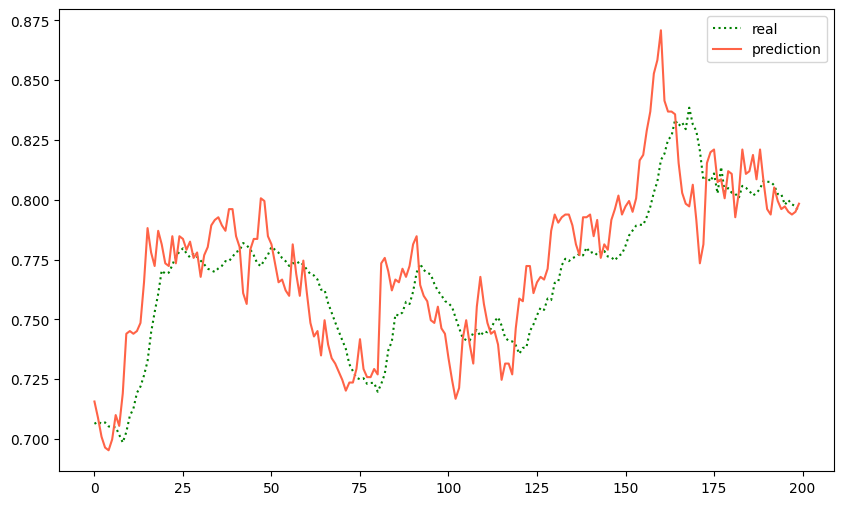

In [38]:
fig, ax = plt.subplots(1, 1)
ax.plot(results, color="green", linestyle="dotted", label="real")
ax.plot(y_valid.detach().cpu().numpy().flatten(),
        color="tomato", label="prediction")
plt.legend()
plt.show()